# Wstęp
Na ostatnich zajęć poznaliśmy nowy typ sieci neuronowych - sieci konwolucyjne **CNN**. To specjalny rodzaj sieci stworzony do przetwarzania danych o strukturze siatki. Wykorzystują one operacje splotu, aby móc wykrywać lokalne cechy (kształty).

# Zadanie 1:
Proszę pobrać zbiór fasion MNIST (torchvision.datasets.FashionMNIST) i zaproponować sieć konwolucyjną do jego klasyfikacji. Dla co najmniej trzech architektur proszę wypisać macierz pomyłek i wykresy funkcji strat podczas uczenia. Proszę spróbować w każdym wypadku podać przynajmniej jeden źle zaklasyfikowany obrazek.


Niezbędne importy.

In [26]:
import torch
import torch.nn as nn  
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")



Device: mps


Pobieramy dane ze zbioru MNIST

In [27]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1000)

Definijemy 3 różne modele sieci konwolucyjnych

CNN1 – najprostsza 1 warstwowa sieć

**Architektura:**

| Warstwa      | Operacja                          | Wymiary danych            |
|--------------|-----------------------------------|---------------------------|
| Wejście      | 1 kanał                           | `1 × 28 × 28`             |
| Conv2d       | 6 filtrów `5×5`, padding=2        | `6 × 28 × 28`             |
| MaxPool2d    | 2×2                               | `6 × 14 × 14`             |
| Flatten      | —                                 | `6 × 14 × 14 = 1176` cech |
| Linear       | `1176 → 10`                       | 10 klas                   |

---

CNN2 – dwuwarstwowa sieć konwolucyjna

**Architektura:**

| Warstwa      | Operacja                          | Wymiary danych            |
|--------------|-----------------------------------|---------------------------|
| Wejście      | 1 kanał                           | `1 × 28 × 28`             |
| Conv2d       | 12 filtrów `5×5`, padding=2       | `12 × 28 × 28`            |
| MaxPool2d    | 2×2                               | `12 × 14 × 14`            |
| Conv2d       | 24 filtrów `3×3`                  | `24 × 12 × 12`            |
| MaxPool2d    | 2×2                               | `24 × 6 × 6`              |
| Flatten      | —                                 | `24 × 6 × 6 = 864` cech   |
| Linear       | `864 → 10`                        | 10 klas                   |

---

CNN3 – głęboka sieć z warstwą ukrytą

**Architektura:**

| Warstwa      | Operacja                          | Wymiary danych            |
|--------------|-----------------------------------|---------------------------|
| Wejście      | 1 kanał                           | `1 × 28 × 28`             |
| Conv2d       | 32 filtrów `3×3`, padding=1       | `32 × 28 × 28`            |
| MaxPool2d    | 2×2                               | `32 × 14 × 14`            |
| Conv2d       | 64 filtrów `3×3`, padding=1       | `64 × 14 × 14`            |
| MaxPool2d    | 2×2                               | `64 × 7 × 7`              |
| Conv2d       | 128 filtrów `3×3`, padding=1      | `128 × 7 × 7`             |
| MaxPool2d    | 2×2                               | `128 × 3 × 3`             |
| Flatten      | —                                 | `128 × 3 × 3 = 1152` cech |
| Linear       | `1152 → 256`                      | Warstwa ukryta            |
| Linear       | `256 → 10`                        | 10 klas                   |


In [28]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(6 * 14 * 14, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = torch.flatten(x, 1)
        return self.fc(x)



class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, padding=2)  
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)            
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                                 
        self.fc = nn.Linear(24 * 6 * 6, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))     
        x = self.pool(F.relu(self.conv2(x)))     
        x = torch.flatten(x, 1)
        return self.fc(x)


class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)     
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)   
        self.pool = nn.MaxPool2d(2, 2)                              
        self.fc1 = nn.Linear(128 * 3 * 3, 256)                      
        self.fc2 = nn.Linear(256, 10)                               

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   
        x = self.pool(F.relu(self.conv2(x)))   
        x = self.pool(F.relu(self.conv3(x)))   
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

Definiujemy funckje do trenowania modeli

In [29]:
def train_model(net, name, epochs=5):
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    loss_history = []
    accuracy_train_history = []
    accuracy_test_history = []
    start_time = time.time()  # ⏱️ start


    for epoch in range(epochs):
        running_loss = 0.0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss_history.append(running_loss / len(trainloader))

        with torch.no_grad():
            net.eval()
            correct_test = 0
            total_test = 0
            correct_train = 0
            total_train = 0

            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

        accuracy_train_history.append(correct_train / total_train)
        accuracy_test_history.append(correct_test / total_test)

        print(f"[{name}] Epoka {epoch+1}/{epochs} - Loss: {loss_history[-1]:.4f}, Train Acc: {accuracy_train_history[-1]*100:.2f}%, Test Acc: {accuracy_test_history[-1]*100:.2f}%")
    
    end_time = time.time()  # ⏱️ stop
    elapsed = end_time - start_time
    print(f"[{name}] Trening zakończony w {elapsed:.2f} sekundach.\n")

    return loss_history, accuracy_train_history, accuracy_test_history


In [30]:
def show_confusion_matrix(model, dataloader, class_names, title="Macierz pomyłek"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Przewidziana klasa")
    plt.ylabel("Rzeczywista klasa")
    plt.title(title)
    plt.show()


In [31]:
def show_random_misclassified(model, dataloader, class_names, title="Błędna klasyfikacja (losowa)"):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified.append((inputs[i].cpu(), predicted[i].item(), labels[i].item()))

    if not misclassified:
        print("Model nie popełnił żadnego błędu (?!), gratulacje :)")
        return

    # Wybierz losowy przykład z listy
    img, pred_idx, true_idx = random.choice(misclassified)
    img = img.squeeze()

    plt.imshow(img, cmap="gray")
    plt.title(f"{title}\nPrawdziwa: {class_names[true_idx]}, Przewidziana: {class_names[pred_idx]}")
    plt.axis("off")
    plt.show()

In [32]:
device = torch.device("cpu")
print(f"Device: {device}")
models = {
    "CNN1": CNN1(),
    "CNN2": CNN2(),
    "CNN3": CNN3()
}

results = {}

for name, model in models.items():
    print(f"\nTrenowanie modelu: {name}")
    loss, acc_train, acc_test = train_model(model, name)
    results[name] = {
        "loss": loss,
        "acc_train": acc_train,
        "acc_test": acc_test
    }
    
    


Device: cpu

Trenowanie modelu: CNN1
[CNN1] Epoka 1/5 - Loss: 0.5133, Train Acc: 86.60%, Test Acc: 85.26%
[CNN1] Epoka 2/5 - Loss: 0.3590, Train Acc: 88.31%, Test Acc: 87.23%
[CNN1] Epoka 3/5 - Loss: 0.3239, Train Acc: 89.24%, Test Acc: 88.25%
[CNN1] Epoka 4/5 - Loss: 0.3036, Train Acc: 90.23%, Test Acc: 88.56%
[CNN1] Epoka 5/5 - Loss: 0.2890, Train Acc: 90.50%, Test Acc: 88.78%
[CNN1] Trening zakończony w 53.10 sekundach.


Trenowanie modelu: CNN2
[CNN2] Epoka 1/5 - Loss: 0.5128, Train Acc: 86.92%, Test Acc: 86.29%
[CNN2] Epoka 2/5 - Loss: 0.3441, Train Acc: 88.35%, Test Acc: 87.36%
[CNN2] Epoka 3/5 - Loss: 0.3075, Train Acc: 89.20%, Test Acc: 87.60%
[CNN2] Epoka 4/5 - Loss: 0.2822, Train Acc: 90.74%, Test Acc: 89.24%
[CNN2] Epoka 5/5 - Loss: 0.2641, Train Acc: 91.10%, Test Acc: 89.37%
[CNN2] Trening zakończony w 86.98 sekundach.


Trenowanie modelu: CNN3
[CNN3] Epoka 1/5 - Loss: 0.4595, Train Acc: 89.85%, Test Acc: 88.60%
[CNN3] Epoka 2/5 - Loss: 0.2814, Train Acc: 90.54%, Test Acc: 

Wytrenowaliśmy 3 wcześniej zdefiniowane modele.
Po zmierzeniu czasów widać znączący wzrost czasu treningu przy zwiększaniu ilości warstw naszego modelu.
Następnie narysowaliśmy wykresy funkcji straty oraz wykres dokładności dla każdego z modeli i porównaliśmy je ze sobą.

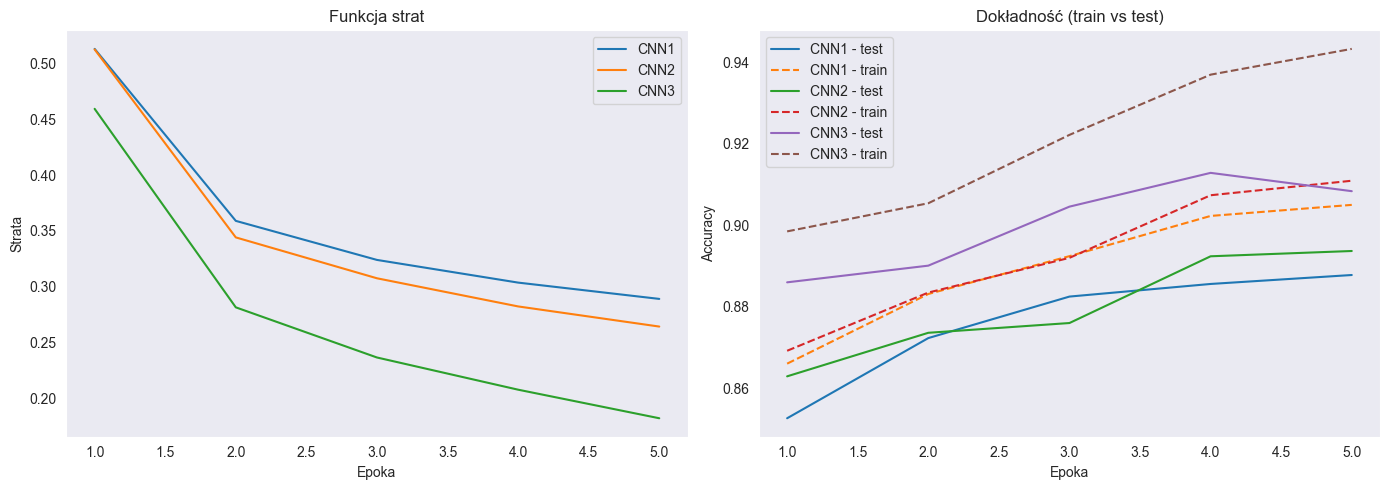

In [33]:
epochs = range(1, 6)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for name in results:
    plt.plot(epochs, results[name]["loss"], label=name)
plt.title("Funkcja strat")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
for name in results:
    plt.plot(epochs, results[name]["acc_test"], label=f"{name} - test")
    plt.plot(epochs, results[name]["acc_train"], linestyle="--", label=f"{name} - train")
plt.title("Dokładność (train vs test)")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


### Funkcja strat:
- Im większa ilość warstw w modelu tym szybciej maleje
- Dwa pierwsze modele uzyskały podobną końcową wartość, natomiast trzeci model uzyskał znacznie lepszy wynik
### Funkcja dokładności:
- Dwa pierwsze modele wykazywały bardzo podobną dokładność zarówno dla danych testowych jak i treningowych, z końcową wartością około test - 89%, train - 90%. 
- Nie wykazują one oznak przeuczenia (dokładność dla danych testowych oraz treningów jest bardzo zbliżona)
- Model 3 uzyskał delikatnie lepszą dokładność dla danych testowych - 91%, natomiast dla danych treningowych wzrost jest większy i końcowa wartość wynosi ok. 94,5%
- Moim zdaniem z racji na większą ilość warstw w modelu 3 zjawisko przeuczenia powoli zaczęło się pokazywać, co można zauważyc po zwiększneiu się różnicy między dokładnością da danych treningowych, a testowych. Natomiast różnica około 3% to nadal jest wartość w normie, także nie możemy uznać, że model ten rzeczywiście się przeuczył. 

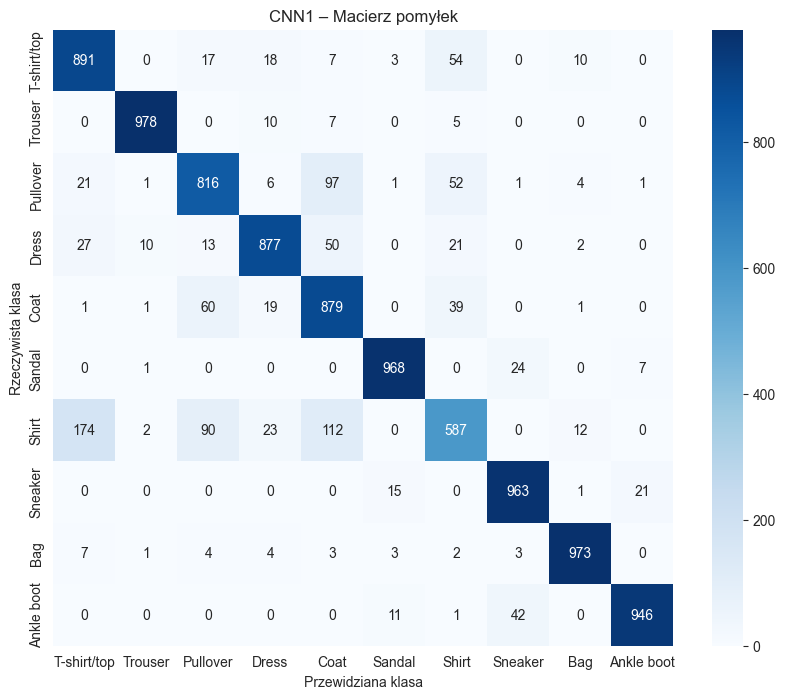

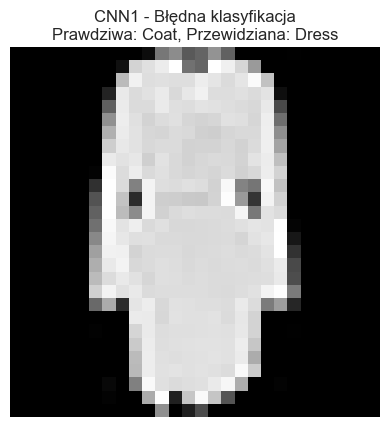

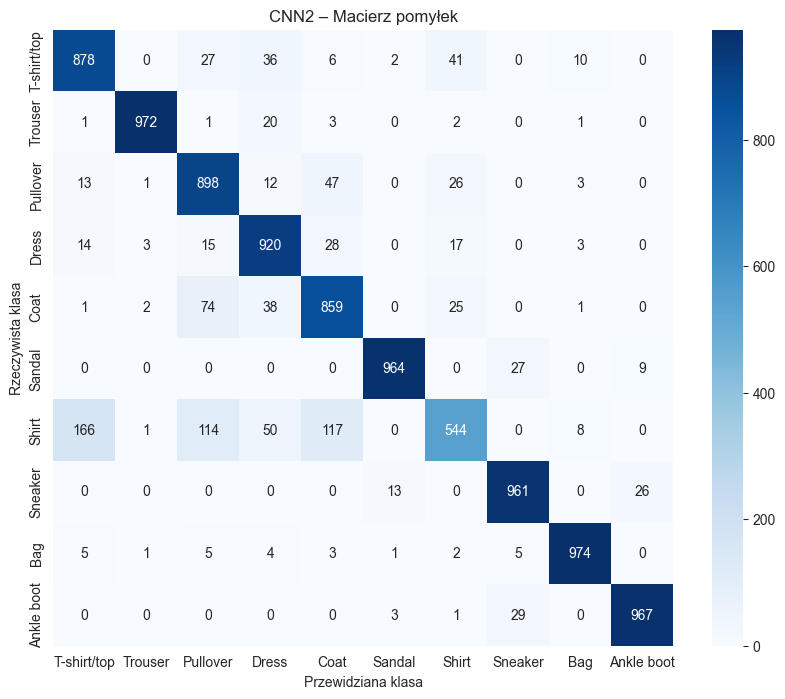

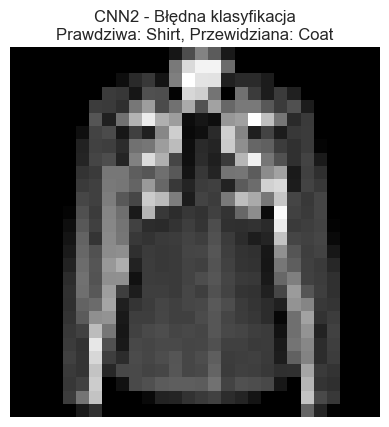

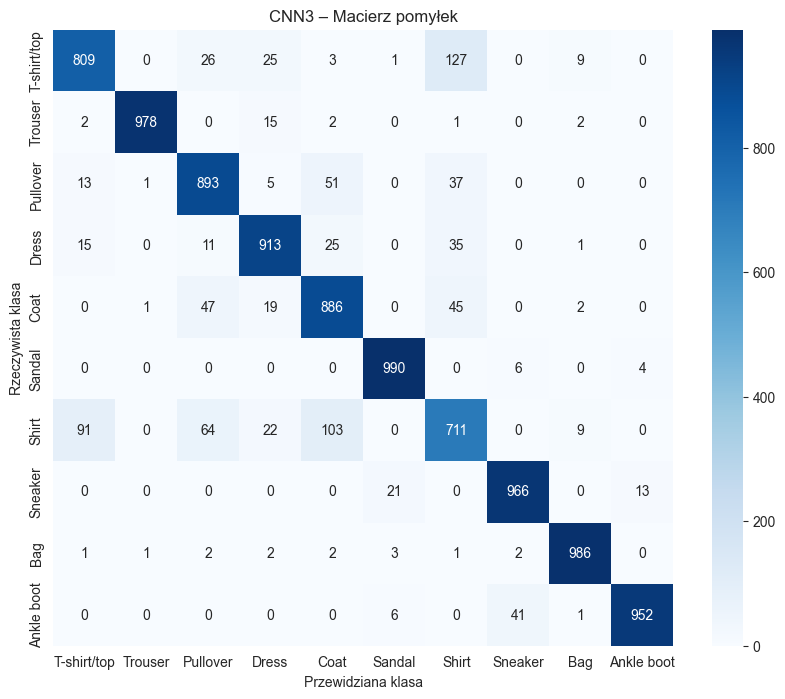

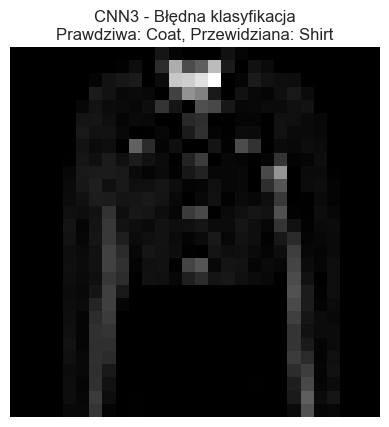

In [34]:
class_names = train_dataset.classes
for name, model in models.items():
    show_confusion_matrix(model, testloader, class_names, title=f"{name} – Macierz pomyłek")
    show_random_misclassified(model, testloader, class_names, title=f"{name} - Błędna klasyfikacja")


### Macierze pomyłek oraz złe dopasowania:
Po przeanalizowaniu macierzy pomyłek dla każdego z modelu można dojść do wniosku, iż modele dobrze przewidują. Modele najczęściej myliły się w dopasowaniu koszuli. W związku ze słabą jakością obrazów ze zbioru danych modele nie miały łatwo. Z obiektywnego punktu widzenia, nawet dla człowieka niektóre obrazy mogą być trudne do jednoznacznej klasyfikacji, co potwierdzają przykłady błędnych predykcji modelu.

# Zadanie 2:
Dla jednej wybranej architektury, proszę porównać czas uczenia sieci na CPU i na GPU, do czego mogą Państwo wykorzystać własną kartę NVidii lub zasoby Colaba. W Runtime->Change Runtime Type musi być zaznaczona opcja "T4 GPU".

W tym przypadku nie zastosowałem się w pełni do polecenia, ponieważ skorzystam z mojego własnego GPU na macu, które nie posiada CUDA, natomiast pytorch niedawno wprowadził opcję użycia rdzieni graficznych również na urządzeniach apple. Mps to backend w PyTorch, który pozwala korzystać z akceleracji GPU na Macach (czyli z Apple Silicon – M1, M2, M3 itd.) poprzez Metal API. W skrócie jest to taki odpowiednik CUDA, ale dla apple. Wyniki również znacząco będą się różnić także uważam, że taki test jest tak samo wartościowy jak z użyciem hardware'u colaba.


Trenowanie modelu: CNN3
[CNN3] Epoka 1/5 - Loss: 0.4594, Train Acc: 89.56%, Test Acc: 88.57%
[CNN3] Epoka 2/5 - Loss: 0.2804, Train Acc: 90.52%, Test Acc: 88.85%
[CNN3] Epoka 3/5 - Loss: 0.2317, Train Acc: 92.66%, Test Acc: 90.40%
[CNN3] Epoka 4/5 - Loss: 0.2000, Train Acc: 94.12%, Test Acc: 91.15%
[CNN3] Epoka 5/5 - Loss: 0.1742, Train Acc: 93.93%, Test Acc: 91.01%
[CNN3] Trening zakończony w 105.75 sekundach.


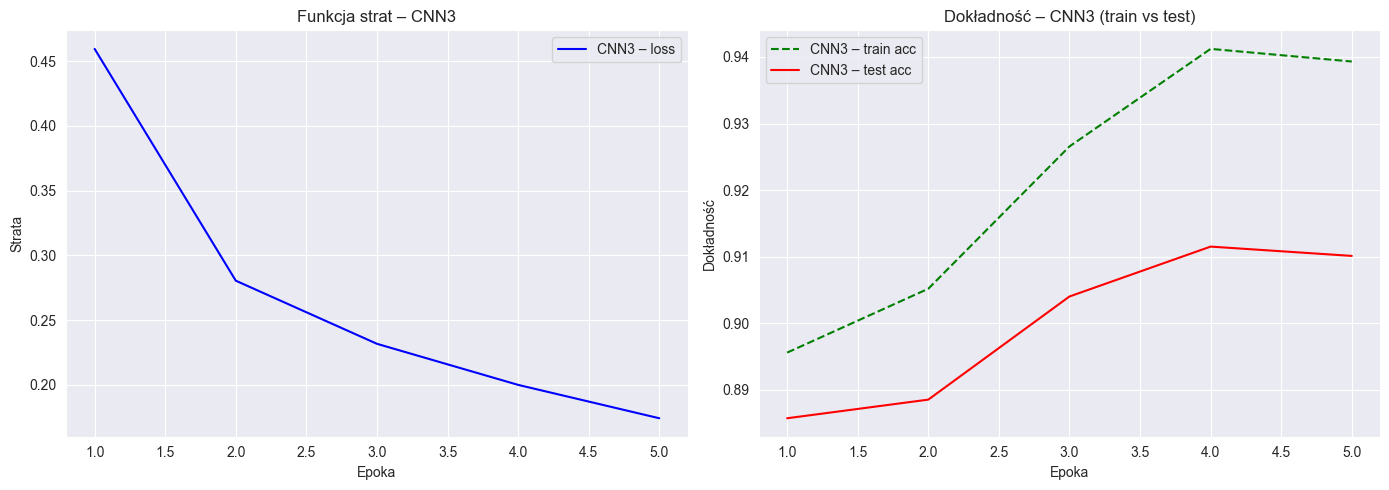

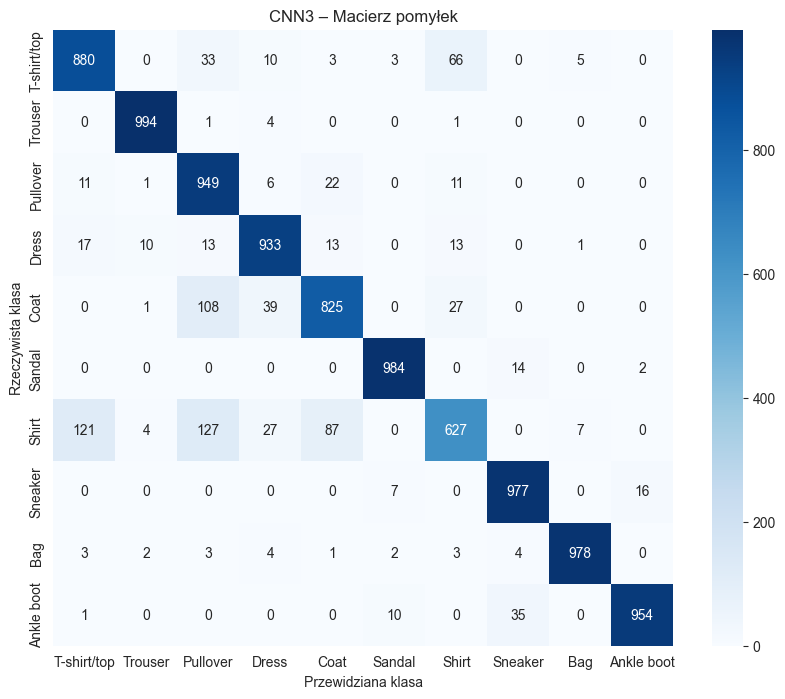

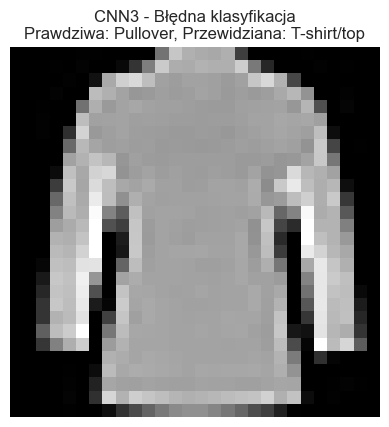

In [35]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model3 = CNN3()
print(f"\nTrenowanie modelu: CNN3")
loss, acc_train, acc_test = train_model(model3, "CNN3")
results["CNN3"] = {
    "loss": loss,
    "acc_train": acc_train,
    "acc_test": acc_test
}
epochs = range(1, 6)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, results["CNN3"]["loss"], label="CNN3 – loss", color="blue")
plt.title("Funkcja strat – CNN3")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, results["CNN3"]["acc_train"], label="CNN3 – train acc", linestyle="--", color="green")
plt.plot(epochs, results["CNN3"]["acc_test"], label="CNN3 – test acc", color="red")
plt.title("Dokładność – CNN3 (train vs test)")
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
show_confusion_matrix(model3, testloader, class_names, title=f"CNN3 – Macierz pomyłek")
show_random_misclassified(model3, testloader, class_names, title=f"CNN3 - Błędna klasyfikacja")

## Wnioski
Jeśli chodzi o samą architekturę model to poradziła ona sobie tak samo jak przy użyciu cpu, co oczywiście było do przewidzenia, bo to z jakiego hardware'u korzystamy podczas treningu nie wpływa na wyniki. Jeśli jednak chodzi o czas treningu to uzyskaliśmy czas ponad dwukrotnie lepszy (105s vs 250s), co dowodzi tezie ,że procesory graficzne o wiele lepiej dają sobie rade z operacjami na macierzach.